# Import libraries

In [1]:
!pip install pandas_ta
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=fa963a565d176712f604493938b294c41de66f6a276acdc46d1ba7b205f6271d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## cac

### Data Insights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cac = pd.read_csv('/content/drive/MyDrive/ML_project/Data/Cac_weekly.csv')

In [5]:
cac.head()

,Date,Open,High,Low,Close,Volume
0,1994-03-06,2222.96,2241.72,2079.92,2178.69,0.0
1,1994-03-13,2199.09,2225.48,2164.52,2174.91,0.0
2,1994-03-20,2196.77,2260.60,2196.77,2221.34,0.0
3,1994-03-27,2205.56,2225.15,2113.55,2136.62,0.0
4,1994-04-03,2136.42,2165.83,2069.37,2081.94,0.0


In [6]:
cac.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    0
dtype: int64

In [7]:
# Handle NaN:
cac.dropna(inplace=True)

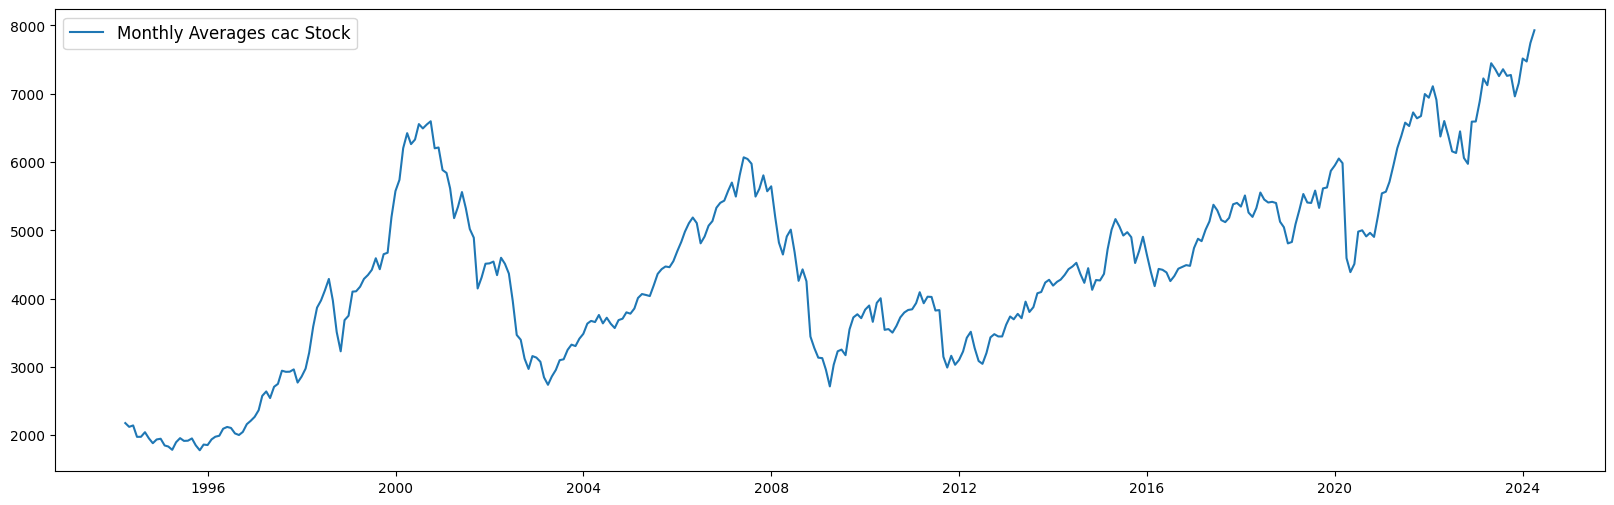

In [8]:
cac['Date'] = pd.to_datetime(cac.Date)
newcac = cac.set_index('Date')
# Resample the data to the monthly level
monthly_data = newcac[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages cac Stock')
plt.legend(prop={'size': 12})
plt.show()

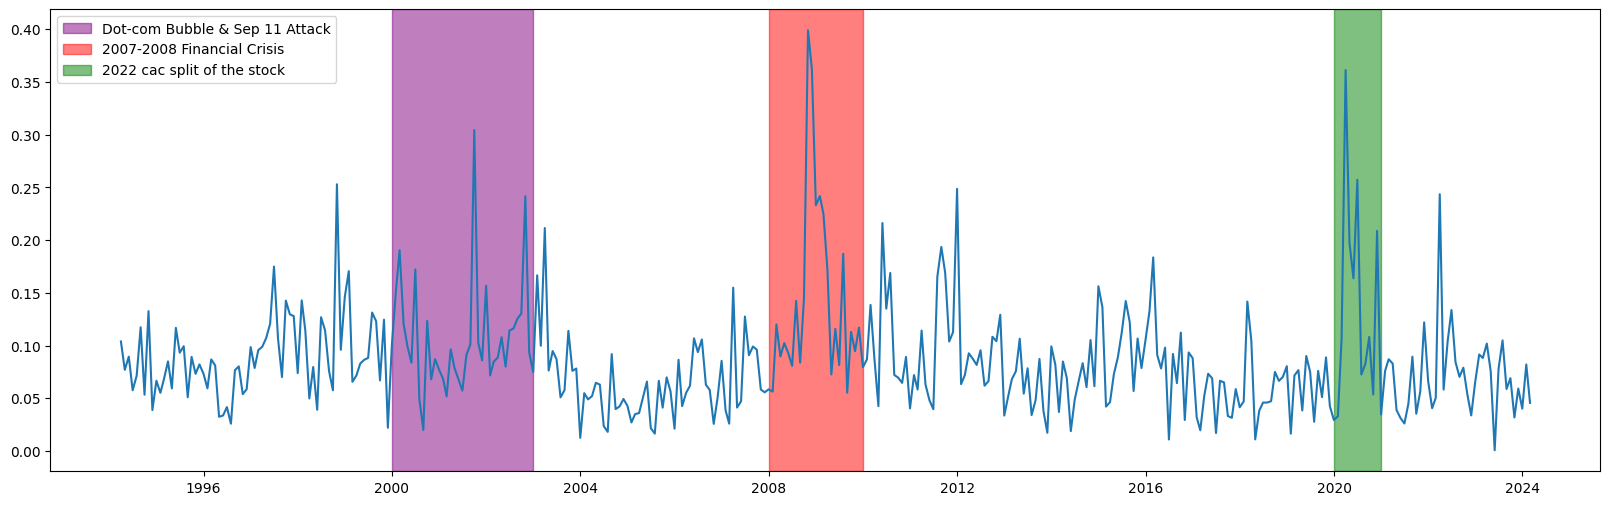

In [9]:
# Calculate weekly returns using percentage change
weekly_returns = newcac['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2008', '2010', color='red', alpha=.5)
plt.axvspan('2020', '2021', color='green', alpha=.5)
#plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 cac split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

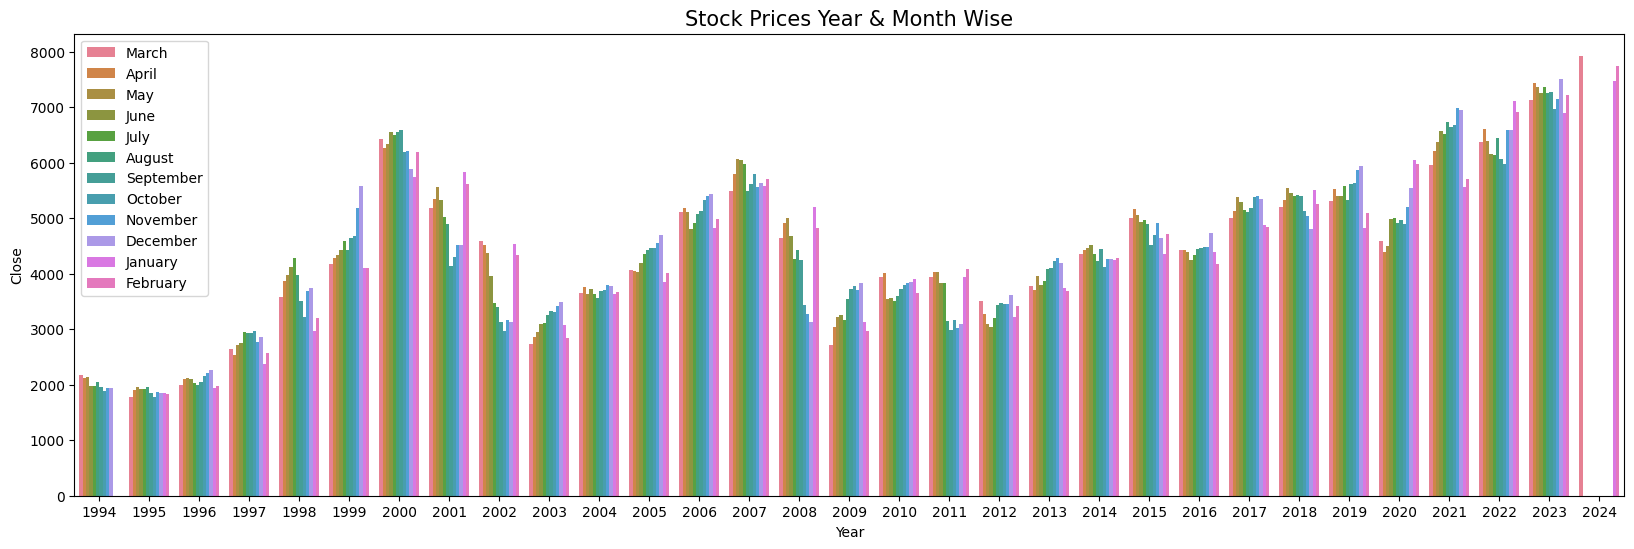

In [10]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

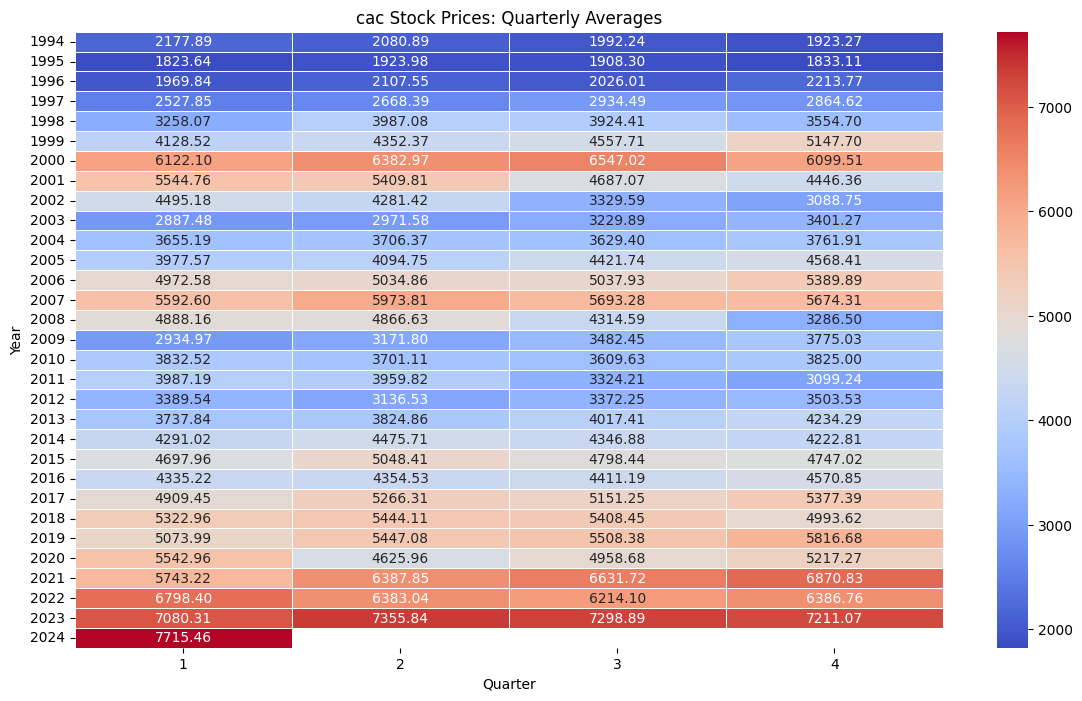

In [11]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("cac Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [12]:
# Create Log(Return)
# Calculate logarithmic returns
cac['Log_Return'] = np.log(cac['Close'] / cac['Close'].shift(1))
cac['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [13]:
# Calculate Simple Moving Average (SMA)
cac['SMA_50'] = ta.sma(cac['Close'], length=50)  # 50-period SMA
cac['SMA_200'] = ta.sma(cac['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
cac['EMA_12'] = ta.ema(cac['Close'], length=12)  # 12-period EMA
cac['EMA_26'] = ta.ema(cac['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(cac['High'], cac['Low'], cac['Close'])
cac = cac.join(stoch)

# Calculate Relative Strength Index (RSI)
cac['RSI_14'] = ta.rsi(cac['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(cac['Close'])
cac = cac.join(macd)

In [14]:
cac['Date'] = pd.to_datetime(cac['Date'])
cac.set_index('Date', inplace=True)

In [15]:
# Handle NaN:
cac.dropna(inplace=True)

In [16]:
cac.shape

(1365, 16)

In [17]:
dates = cac.index

In [18]:
# Calculate split indices
split_idx_train = int(len(cac) * 0.7)
split_idx_val = int(len(cac) * 0.9)

# Drop the specified columns and define the features and labels
X_cac = cac.drop(['Log_Return'], axis=1)
y_cac = cac['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_cac.reset_index(drop=True, inplace=True)
y_cac.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_cac_train = X_cac.iloc[:split_idx_train, :]
X_cac_val = X_cac.iloc[split_idx_train:split_idx_val, :]
X_cac_test = X_cac.iloc[split_idx_val:, :]

y_cac_train = y_cac.iloc[:split_idx_train]
y_cac_val = y_cac.iloc[split_idx_train:split_idx_val]
y_cac_test = y_cac.iloc[split_idx_val:]

In [19]:
cac_dates_test = dates[split_idx_val:]

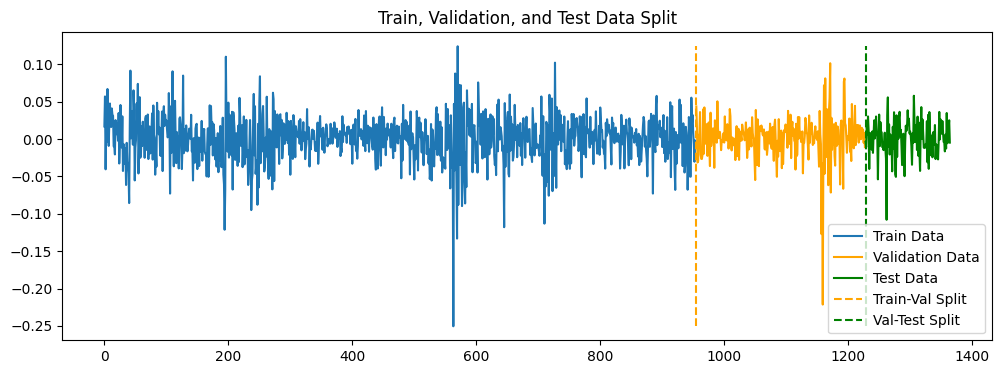

In [20]:
# Indices for plotting
x_train = np.arange(len(y_cac_train))
x_val = np.arange(len(y_cac_train), len(y_cac_train) + len(y_cac_val))
x_test = np.arange(len(y_cac_train) + len(y_cac_val), len(y_cac))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_cac_train, label="Train Data")
plt.plot(x_val, y_cac_val, color='orange', label="Validation Data")
plt.plot(x_test, y_cac_test, color='green', label="Test Data")
plt.vlines(len(y_cac_train), ymin=min(y_cac.min(), y_cac.min(), y_cac.min()), ymax=max(y_cac.max(), y_cac.max(), y_cac.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_cac_train) + len(y_cac_val), ymin=min(y_cac.min(), y_cac.min(), y_cac.min()), ymax=max(y_cac.max(), y_cac.max(), y_cac.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [21]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_cac_train_transformed = power_transform(X_cac_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_cac_val_transformed = power_transform(X_cac_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_cac_test_transformed = power_transform(X_cac_test.to_numpy(), method='yeo-johnson')

In [22]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_cac_train_scaled = scaler.fit_transform(X_cac_train_transformed)

# Transform the val data using the same scaler
X_cac_val_scaled = scaler.transform(X_cac_val_transformed)

# Transform the test data using the same scaler
X_cac_test_scaled = scaler.transform(X_cac_test_transformed)

In [23]:
print(X_cac_train_scaled.shape)
print(X_cac_val_scaled.shape)
print(X_cac_test_scaled.shape)

(955, 15)
(273, 15)
(137, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [24]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [25]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [26]:
# Ensure y_cac_train and y_test are numpy arrays
y_cac_train = y_cac_train.to_numpy() if isinstance(y_cac_train, pd.Series) else y_cac_train
y_cac_val = y_cac_val.to_numpy() if isinstance(y_cac_val, pd.Series) else y_cac_val
y_cac_test = y_cac_test.to_numpy() if isinstance(y_cac_test, pd.Series) else y_cac_test

# Create sequences
time_steps = 10
X_cac_train_seq, y_cac_train_seq = create_sequences_rnns(X_cac_train_scaled, y_cac_train, time_steps)
X_cac_val_seq, y_cac_val_seq = create_sequences_rnns(X_cac_val_scaled, y_cac_val, time_steps)
X_cac_test_seq, y_cac_test_seq = create_sequences_rnns(X_cac_test_scaled, y_cac_test, time_steps)

X_cac_train_tensor = torch.tensor(X_cac_train_seq, dtype=torch.float32)
y_cac_train_tensor = torch.tensor(y_cac_train_seq, dtype=torch.float32)
X_cac_val_tensor = torch.tensor(X_cac_val_seq, dtype=torch.float32)
y_cac_val_tensor = torch.tensor(y_cac_val_seq, dtype=torch.float32)
X_cac_test_tensor = torch.tensor(X_cac_test_seq, dtype=torch.float32)
y_cac_test_tensor = torch.tensor(y_cac_test_seq, dtype=torch.float32)

# Prepare data loaders
cac_train_dataset = TensorDataset(X_cac_train_tensor, y_cac_train_tensor)
cac_train_loader = DataLoader(dataset=cac_train_dataset, batch_size=32, shuffle=True)
cac_val_dataset = TensorDataset(X_cac_val_tensor, y_cac_val_tensor)
cac_val_loader = DataLoader(dataset=cac_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
cac_predict_dataset = TensorDataset(X_cac_test_tensor, y_cac_test_tensor)
cac_predict_loader = DataLoader(cac_predict_dataset, batch_size=32, shuffle=False)

In [27]:
X_cac_train_tensor.shape

torch.Size([945, 10, 15])

In [28]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [52]:
# Initialize the RNN model
cac_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(cac_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(cac_rnns_rmse, cac_train_loader, cac_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.07739182561635971, Val Loss: 0.06393232196569443
Epoch 11, Train Loss: 0.02463647909462452, Val Loss: 0.031912628561258316
Epoch 21, Train Loss: 0.030102362856268883, Val Loss: 0.028235865756869316
Epoch 31, Train Loss: 0.03067224845290184, Val Loss: 0.029593050479888916
Epoch 41, Train Loss: 0.023989412933588028, Val Loss: 0.03135891258716583
Epoch 51, Train Loss: 0.027727503329515457, Val Loss: 0.029605984687805176
Epoch 61, Train Loss: 0.031267423182725906, Val Loss: 0.03371639922261238
Epoch 71, Train Loss: 0.030542515218257904, Val Loss: 0.03417908027768135
Epoch 81, Train Loss: 0.020689720287919044, Val Loss: 0.034416910260915756
Epoch 91, Train Loss: 0.028218701481819153, Val Loss: 0.03384749963879585


In [53]:
best_val_loss

tensor(0.0275)

In [54]:
cac_rnns_rmse.load_state_dict(best_model_state)
cac_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [55]:
cac_predictions = []
cac_actuals = []

with torch.no_grad():
    for inputs, labels in cac_predict_loader:
        outputs = cac_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        cac_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        cac_actuals.extend(labels.cpu().numpy())

In [56]:
cac_rnns_rmse_predictions = np.array(cac_predictions)
cac_rnns_rmse_actuals = np.array(cac_actuals)

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming cac_rnns_rmse_predictions and cac_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
cac_rnns_rmse_predicted_labels = (cac_rnns_rmse_predictions >= 0).astype(int)
cac_rnns_rmse_actual_labels = (cac_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
cac_rnns_rmse_accuracy = accuracy_score(cac_rnns_rmse_actual_labels, cac_rnns_rmse_predicted_labels)
cac_rnns_rmse_precision = precision_score(cac_rnns_rmse_actual_labels, cac_rnns_rmse_predicted_labels)
cac_rnns_rmse_recall = recall_score(cac_rnns_rmse_actual_labels, cac_rnns_rmse_predicted_labels)
cac_rnns_rmse_f1 = f1_score(cac_rnns_rmse_actual_labels, cac_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", cac_rnns_rmse_accuracy)
print("Precision:", cac_rnns_rmse_precision)
print("Recall:", cac_rnns_rmse_recall)
print("F1 Score:", cac_rnns_rmse_f1)

Accuracy: 0.5039370078740157
Precision: 0.5625
Recall: 0.391304347826087
F1 Score: 0.46153846153846156


###### Plots

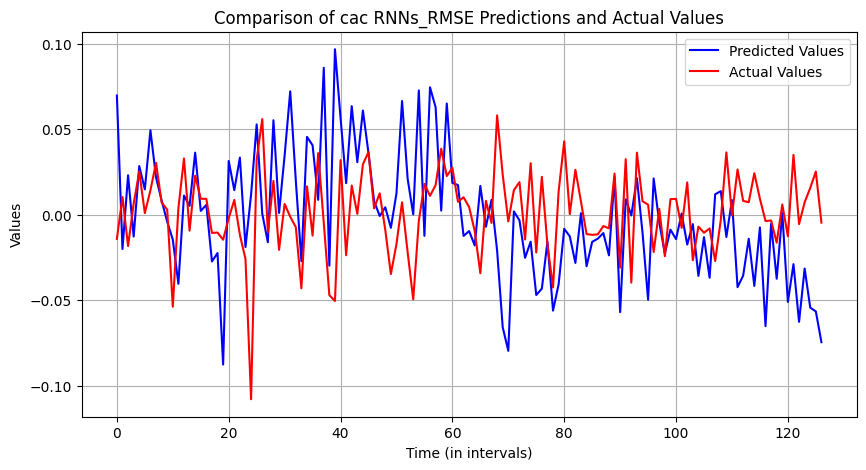

In [36]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(cac_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(cac_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of cac RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

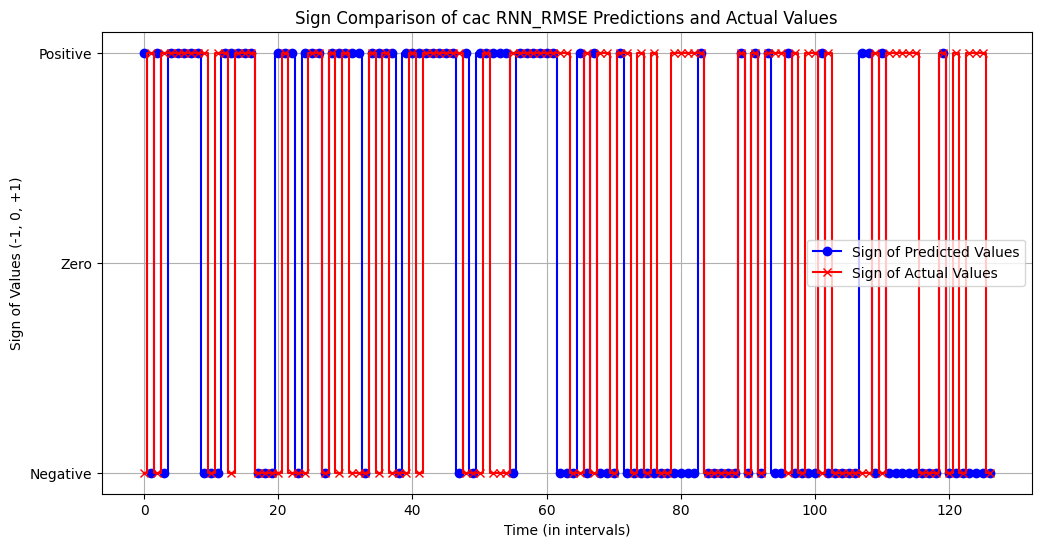

In [37]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(cac_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(cac_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of cac RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
X_cac_train_anfis = torch.tensor(X_cac_train_scaled, dtype=torch.float32)
y_cac_train_anfis = torch.tensor(y_cac_train, dtype=torch.float32)
X_cac_val_anfis = torch.tensor(X_cac_val_scaled, dtype=torch.float32)
y_cac_val_anfis = torch.tensor(y_cac_val, dtype=torch.float32)
X_cac_test_anfis = torch.tensor(X_cac_test_scaled, dtype=torch.float32)
y_cac_test_anfis = torch.tensor(y_cac_test, dtype=torch.float32)

In [ ]:
X_cac_train_anfis.shape

torch.Size([955, 15])

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_cac_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.008

# Initialize the ANFIS model
cac_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
cac_anfis_rmse.fit(X_cac_train_anfis, y_cac_train_anfis
                      , X_cac_val_anfis, y_cac_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
cac_anfis_rmse_predictions = cac_anfis_rmse.predict(X_cac_test_anfis)

Epoch 1/100, Train Loss: 0.0307, Validation Loss: 0.0054
Epoch 11/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 21/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 31/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 41/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 51/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 61/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 71/100, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 81/100, Train Loss: 0.0007, Validation Loss: 0.0007
Epoch 91/100, Train Loss: 0.0007, Validation Loss: 0.0007
Best Validation Loss: 0.0007


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
cac_anfis_rmse_predictions = cac_anfis_rmse_predictions.detach().cpu().numpy()
cac_anfis_rmse_actuals = y_cac_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(cac_anfis_rmse_predictions)
actual_signs = sign_classify(cac_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
cac_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
cac_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
cac_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
cac_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", cac_anfis_rmse_accuracy)
print("Precision:", cac_anfis_rmse_precision)
print("Recall:", cac_anfis_rmse_recall)
print("F1 Score:", cac_anfis_rmse_f1)

Accuracy: 0.8613138686131386
Precision: 0.85
Recall: 0.9066666666666666
F1 Score: 0.8774193548387097


###### Plots

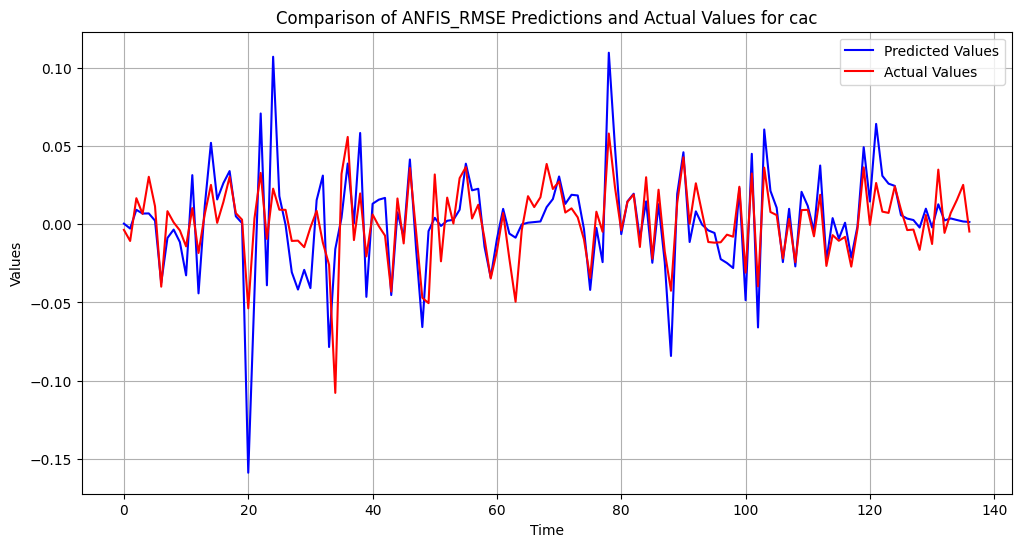

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(cac_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(cac_anfis_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for cac')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

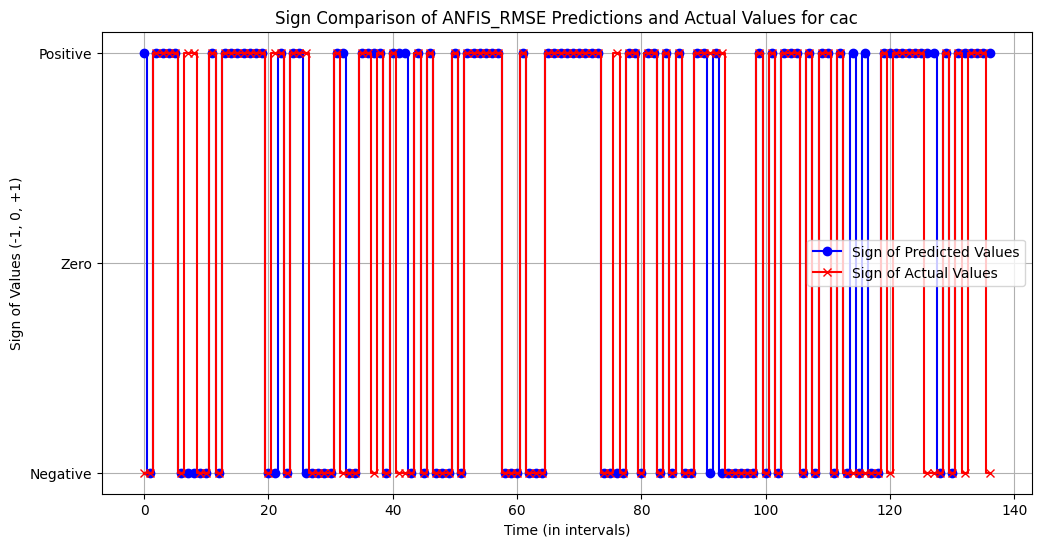

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(cac_anfis_rmse_predictions)
signs_actuals = np.sign(cac_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for cac')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [64]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
cac_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(cac_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(cac_rnns_custom, cac_train_loader, cac_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 2352.944091796875, Val Loss: 2641.3857421875
Epoch 11, Train Loss: 2941.177734375, Val Loss: 2433.039306640625
Epoch 21, Train Loss: 1176.4742431640625, Val Loss: 2522.32373046875
Epoch 31, Train Loss: 2647.06005859375, Val Loss: 2750.498291015625
Epoch 41, Train Loss: 1176.4716796875, Val Loss: 2802.5810546875
Epoch 51, Train Loss: 2647.06005859375, Val Loss: 2653.77197265625
Epoch 61, Train Loss: 2352.942138671875, Val Loss: 2671.133056640625
Epoch 71, Train Loss: 2352.941650390625, Val Loss: 2619.0498046875
Epoch 81, Train Loss: 2352.942138671875, Val Loss: 2619.049560546875
Epoch 91, Train Loss: 1176.4710693359375, Val Loss: 2584.327392578125


In [65]:
best_val_loss

tensor(2311.5142)

In [66]:
cac_rnns_custom.load_state_dict(best_model_state)
cac_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [67]:
cac_predictions = []
cac_actuals = []

with torch.no_grad():
    for inputs, labels in cac_predict_loader:
        outputs = cac_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        cac_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        cac_actuals.extend(labels.cpu().numpy())

In [68]:
cac_rnns_custom_predictions = np.array(cac_predictions)
cac_rnns_custom_actuals = np.array(cac_actuals)

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming cac_rnns_rmse_predictions and cac_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
cac_rnns_custom_predicted_labels = (cac_rnns_custom_predictions >= 0).astype(int)
cac_rnns_custom_actual_labels = (cac_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
cac_rnns_custom_accuracy = accuracy_score(cac_rnns_custom_actual_labels, cac_rnns_custom_predicted_labels)
cac_rnns_custom_precision = precision_score(cac_rnns_custom_actual_labels, cac_rnns_custom_predicted_labels)
cac_rnns_custom_recall = recall_score(cac_rnns_custom_actual_labels, cac_rnns_custom_predicted_labels)
cac_rnns_custom_f1 = f1_score(cac_rnns_custom_actual_labels, cac_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", cac_rnns_custom_accuracy)
print("Precision:", cac_rnns_custom_precision)
print("Recall:", cac_rnns_custom_recall)
print("F1 Score:", cac_rnns_custom_f1)

Accuracy: 0.44881889763779526
Precision: 0.49056603773584906
Recall: 0.37681159420289856
F1 Score: 0.42622950819672134


###### Plots

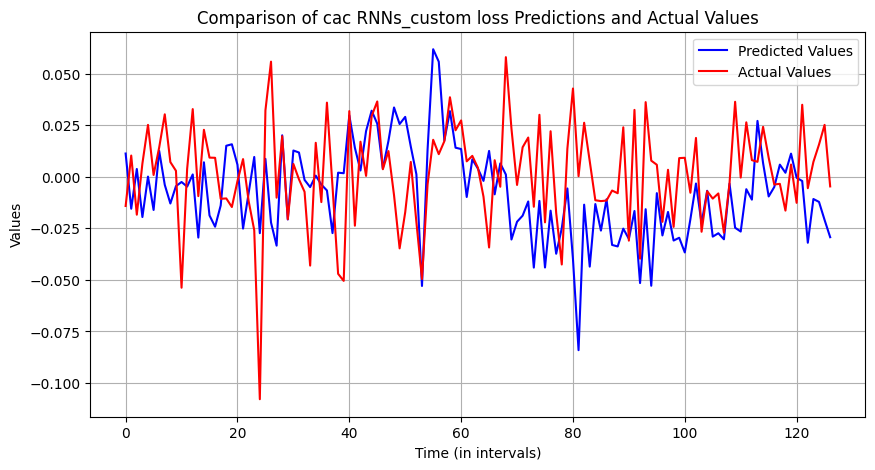

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(cac_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(cac_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of cac RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

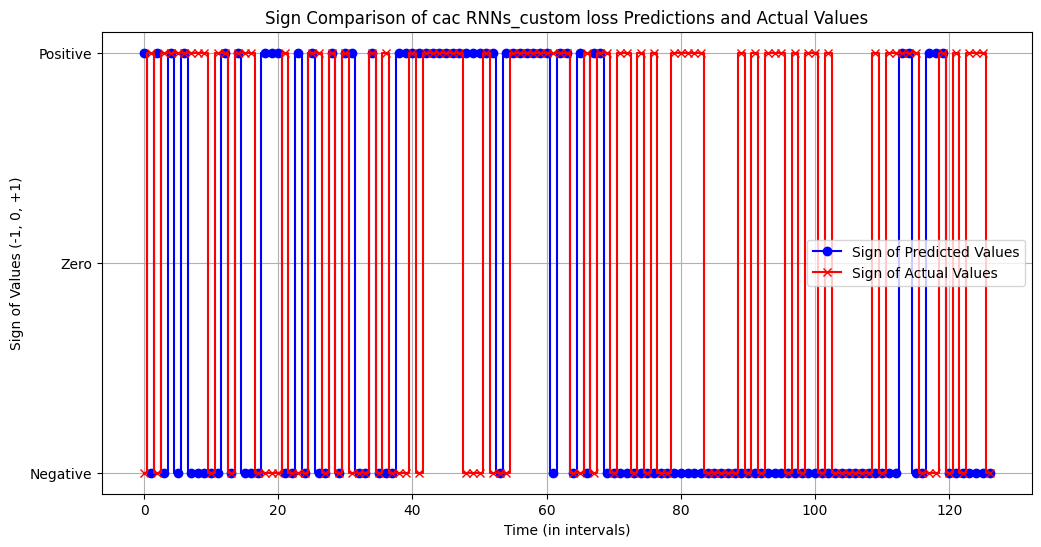

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(cac_rnns_custom_predictions)
signs_actuals_rnn = np.sign(cac_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of cac RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_cac_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.008

# Initialize the ANFIS model
cac_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=10000)

# Train the model
cac_anfis_custom.fit(X_cac_train_anfis, y_cac_train_anfis
                      , X_cac_val_anfis, y_cac_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
cac_anfis_custom_predictions = cac_anfis_custom.predict(X_cac_test_anfis)

Epoch 1/100, Train Loss: 4733.0117, Val Loss: 4578.7593
Epoch 11/100, Train Loss: 3905.7598, Val Loss: 3553.1141
Epoch 21/100, Train Loss: 3759.1631, Val Loss: 3003.6635
Epoch 31/100, Train Loss: 3874.3463, Val Loss: 3553.1140
Epoch 41/100, Train Loss: 3895.2887, Val Loss: 3882.7844
Epoch 51/100, Train Loss: 3445.0268, Val Loss: 3113.5537
Epoch 61/100, Train Loss: 3329.8437, Val Loss: 3076.9236
Epoch 71/100, Train Loss: 3026.1787, Val Loss: 3040.2936
Epoch 81/100, Train Loss: 2439.7912, Val Loss: 2234.4328
Epoch 91/100, Train Loss: 1801.0477, Val Loss: 2307.6928
Best Validation Loss: 1758.2424


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
cac_anfis_custom_predictions = cac_anfis_custom_predictions.detach().cpu().numpy()
cac_anfis_custom_actuals = y_cac_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(cac_anfis_custom_predictions)
actual_signs = sign_classify(cac_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
cac_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
cac_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
cac_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
cac_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", cac_anfis_custom_accuracy)
print("Precision:", cac_anfis_custom_precision)
print("Recall:", cac_anfis_custom_recall)
print("F1 Score:", cac_anfis_custom_f1)

Accuracy: 0.8832116788321168
Precision: 0.8554216867469879
Recall: 0.9466666666666667
F1 Score: 0.8987341772151898


###### Plots

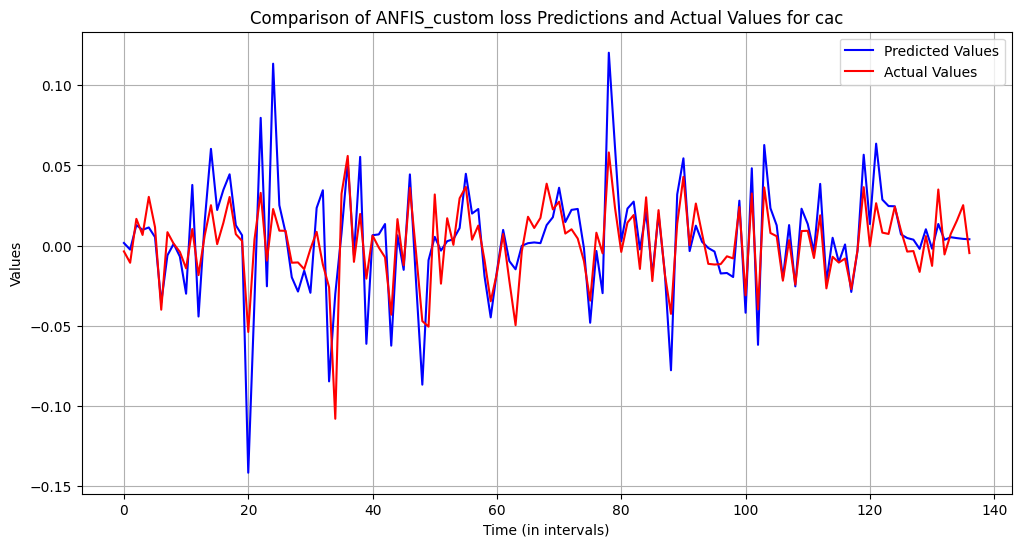

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(cac_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(cac_anfis_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for cac')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

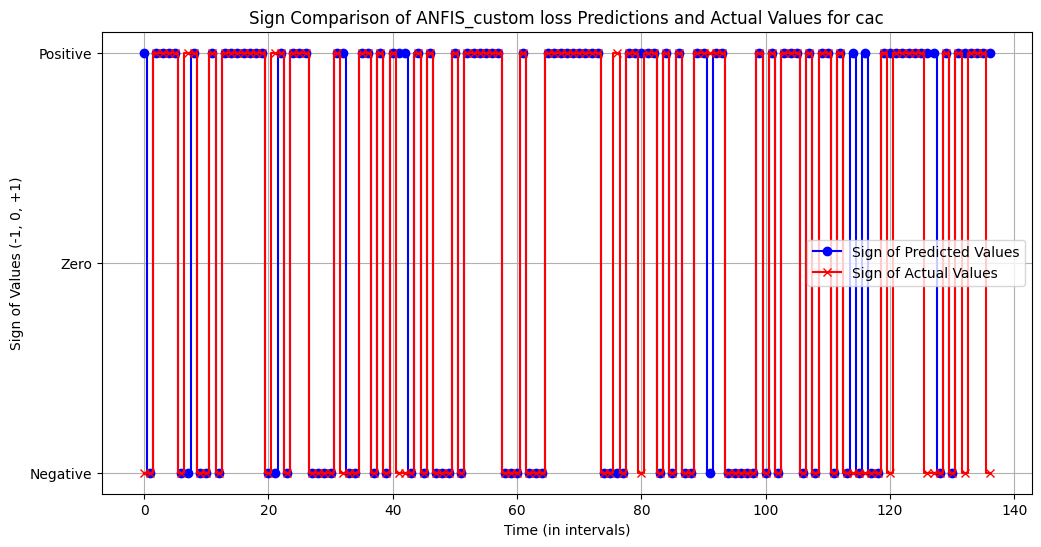

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(cac_anfis_custom_predictions)
signs_actuals = np.sign(cac_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for cac')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()